In [1]:
import torch
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from qmvpa.rsa import inter_RSM, inter_RSMs, correlate_RSMs
from qmvpa.factor import tune_srm, calc_srm_var_exp
from simulation.data_gen import get_XOR_data
from simulation.models import Net, train_net, get_hidden_acts, generate_permuted_params
from simulation.utils import get_random_noise, get_rand_ortho_matrix, correlate_solution_to_truth

sns.set(style='white', context='poster', font_scale=1,
        rc={"lines.linewidth": 2.5})

np.random.seed(0)
torch.manual_seed(0)
%autosave 5 

Autosaving every 5 seconds


In [2]:
n_epochs = 1000
learning_rate = .003
n_hidden = 50
n_features = 2
n_pts_each_cloud = 50
n_nets = 10
noise_level = 0
n_feature_list = [10, 20, 30, 40, 50]
var_threshold = 1
n_sims = 50

In [3]:
# compute the correlation to the ground truth matrix
r_O_mean = {'SRM': [], 'native': []}
tau_O_mean = {'SRM': [], 'native': []}
r_P_mean = {'SRM': [], 'native': []}
tau_P_mean = {'SRM': [], 'native': []}

# sim_id = 0
for sim_id in range(n_sims):
    print('%d ' % sim_id, end='')

    """ generate some XOR data, then train a net """
    # generate some XOR data
    x, y = get_XOR_data(n_pts_each_cloud)
    x_test, y_test = get_XOR_data(n_pts_each_cloud)
    n_examples = len(y)

    # define network
    net = Net(n_feature=n_features, n_hidden=n_hidden, n_output=1)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_func = torch.nn.MSELoss()
    # train the network
    net, accuracy_train, accuracy_test = train_net(
        net, loss_func, optimizer, n_epochs, x, y, x_test, y_test)

    """ generate net copies """
    nets = []
    # sim1 random permutation
    PHs = {'train': [], 'test': []}
    Ps = []
    # sim2 rigid body transformation
    OHs = {'train': [], 'test': []}
    Qs = []

    # get the original hidden activities on the train/test set
    H_train = get_hidden_acts(net, x).T
    H_test = get_hidden_acts(net, x_test).T

    for i in range(n_nets):
        noise_train = get_random_noise((n_hidden, n_examples), noise_level)
        noise_test = get_random_noise((n_hidden, n_examples), noise_level)
        # generate a permutated network 
        param_dict, P = generate_permuted_params(net, n_hidden)
        # clone a net: use the the permutated weights to initialize a network
        clone_net = Net(n_feature=n_features, n_hidden=n_hidden, n_output=1)
        clone_net.load_state_dict(param_dict)
        nets.append(clone_net)
        # get hidden activities on the training and test set 
        noise_train = get_random_noise((n_hidden, n_examples), noise_level)
        noise_test = get_random_noise((n_hidden, n_examples), noise_level)
        # collect results 
        Ps.append(P)
        PHs['train'].append(get_hidden_acts(clone_net, x).T + noise_train)
        PHs['test'].append(get_hidden_acts(clone_net, x_test).T + noise_test)
        
        # get the random rotation matrix and the noise matrix
        Q = get_rand_ortho_matrix(n_hidden)
        # rotate the traning and test set
        OH_train = Q @ H_train + noise_train
        OH_test = Q @ H_test + noise_test
        # collect the matrices
        Qs.append(Q)
        OHs['train'].append(OH_train)
        OHs['test'].append(OH_test)

    """permutation transformation"""
    # the RSM for each permutated network
    RSM_P = {'truth': []}
    # the average RSM for across networks
    avg_RSM_P = {'truth': None, 'SRM': None, 'native': None}
    # compute the RSM within each network
    RSM_P['truth'] = [inter_RSM(PHs['test'][i], PHs['test'][i])
                      for i in range(n_nets)]
    # take the mean as the ground truth
    # this is reasonable because they are similar across nets
    avg_RSM_P['truth'] = np.mean(np.array(RSM_P['truth']), axis=0)
    # demonstrate that across-nets, RSMs are highly similar
    RSM_P_crossnets, _ = correlate_RSMs(RSM_P['truth'])
    # align the permuted networks
    _, PHs_shared, srm_P, var_exp = tune_srm(PHs['train'], PHs['test'], n_feature_list, var_threshold)
    # compute the cross-network item-item correlation in the SRM space
    avg_RSM_P['SRM'] = inter_RSMs(PHs_shared)
    # compute the cross-network item-item correlation in the native space
    avg_RSM_P['native'] = inter_RSMs(PHs['test'])
    # correlation to the mean within-subject RSM before SRM
    temp_corrs = correlate_solution_to_truth(
        avg_RSM_P['SRM'], avg_RSM_P['native'], avg_RSM_P['truth'])
    # r_P_mean['SRM'], tau_P_mean['SRM'], r_P_mean['native'], tau_P_mean['native'] = temp_corrs
    r_P_mean_SRM, tau_P_mean_SRM, r_P_mean_native, tau_P_mean_native = temp_corrs
    # collect results    
    r_P_mean['SRM'].append(r_P_mean_SRM)
    tau_P_mean['SRM'].append(tau_P_mean_SRM)
    r_P_mean['native'].append(r_P_mean_native)
    tau_P_mean['native'].append(tau_P_mean_native)

    """orthogonal transformation"""
    # now align the hidden activities transformed by random orthogonal matrices
    RSM_O = {'truth': []}
    avg_RSM_O = {'truth': None, 'SRM': None, 'native': None}
    # compute the RSM within each network
    RSM_O['truth'] = [inter_RSM(OHs['test'][i], OHs['test'][i])
                      for i in range(n_nets)]
    # take the mean as the ground truth
    # this is reasonable because they are similar across nets
    avg_RSM_O['truth'] = np.mean(np.array(RSM_O['truth']), axis=0)
    # demonstrate that across-nets, RSMs are highly similar
    RSM_O_crossnets, _ = correlate_RSMs(RSM_O['truth'])
    # align the permuted networks
    _, OHs_shared, srm_O, var_exp = tune_srm(
        OHs['train'], OHs['test'], n_feature_list, var_threshold)
    # compute the cross-network item-item correlation in the SRM space
    avg_RSM_O['SRM'] = inter_RSMs(OHs_shared)
    # compute the cross-network item-item correlation in the native space
    avg_RSM_O['native'] = inter_RSMs(OHs['test'])
    # correlation to the mean within-subject RSM before SRM
    temp_corrs = correlate_solution_to_truth(
        avg_RSM_O['SRM'], avg_RSM_O['native'], avg_RSM_O['truth'])
    r_O_mean_SRM, tau_O_mean_SRM, r_O_mean_native, tau_O_mean_native = temp_corrs
    # collect results
    r_O_mean['SRM'].append(r_O_mean_SRM)
    tau_O_mean['SRM'].append(tau_O_mean_SRM)
    r_O_mean['native'].append(r_O_mean_native)
    tau_O_mean['native'].append(tau_O_mean_native)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

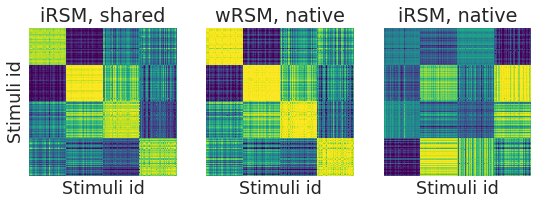

In [4]:
"""demo
"""

temp_heat_maps = [
    avg_RSM_O['SRM'], avg_RSM_O['truth'], avg_RSM_O['native']
]
axes_titles = ['iRSM, shared', 'wRSM, native', 'iRSM, native']


# plot 
f, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
vmin_val, vmax_val = -1, 1

for i_cond in range(3):
    sns.heatmap(
#         temp_heat_maps[i_cond][:100,:100], 
        temp_heat_maps[i_cond], 
        cmap='viridis',
        square=True, robust = True, 
#         vmin = vmin_val, vmax = vmax_val,
        cbar=False, 
        xticklabels=False, yticklabels=False, 
        ax=axes[i_cond])

# set labels, titles

axes[0].set_ylabel('Stimuli id')
for i in range(3): 
    axes[i].set_xlabel('Stimuli id')
    axes[i].set_title(axes_titles[i])
# f.tight_layout()


temp_path = '/tigress/qlu/logs/temp/'
f.savefig(os.path.join(temp_path, 'sim_3mat.png'),  dpi = 500)

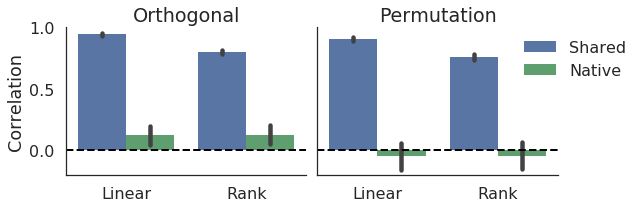

In [5]:
# collect data 
df_O = pd.DataFrame(
    {"Correlation": r_O_mean['SRM'] + r_O_mean['native'] + tau_O_mean['SRM'] + tau_O_mean['native'],
     "Measure": ['Linear'] * n_sims * 2 + ['Rank'] * n_sims * 2,
     "Space": ['Shared'] * n_sims + ['Native'] * n_sims + ['Shared'] * n_sims + ['Native'] * n_sims})

df_P = pd.DataFrame(
    {"Correlation": r_P_mean['SRM'] + r_P_mean['native'] + tau_P_mean['SRM'] + tau_P_mean['native'],
     "Measure": ['Linear'] * n_sims * 2 + ['Rank'] * n_sims * 2,
     "Space": ['Shared'] * n_sims + ['Native'] * n_sims + ['Shared'] * n_sims + ['Native'] * n_sims})

# set plot params 
df_list = [df_O, df_P]
titles_list = ['Orthogonal', 'Permutation']
ci_val = 95 

# plot 
f, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)

for i in range(2): 
    sns.barplot(
        x="Measure", y="Correlation", hue="Space", 
        ci=ci_val, 
        data=df_list[i], 
        ax=axes[i],
    )    
    # general across axes
    sns.despine() 
    axes[i].axhline(0, linestyle='--', linewidth=2, color='k')
    axes[i].set_title(titles_list[i])
    axes[i].set_xlabel('')
    axes[i].set_ylim([-.2, 1])

# specific to the ax
axes[0].legend_.remove()
axes[1].legend(frameon=False, bbox_to_anchor=(.8, 1.01))
axes[1].set_ylabel('')

f.tight_layout()

# # title_text = """
# # Reconstruction: shared RSM
# # After permutation transformation
# # """
# title_text = """
# Permutation transformation
# """
# ax.set_title(title_text)

f.tight_layout()

temp_path = '/tigress/qlu/logs/temp/'
f.savefig(os.path.join(temp_path, 'group_OP.png'),  dpi = 500)